In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from model_Unet import UNET
from dataset_file import *
from train_file import * 
import matplotlib.pyplot as plt

In [2]:
dataset = LipsSet('.', 'images', 'proper_masks')
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

c:\Users\aleks\OneDrive\Documents\LIPS SEGMENTATION\dataset_file.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  mask = torch.as_tensor([cls_mask_1], dtype=torch.float)


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)


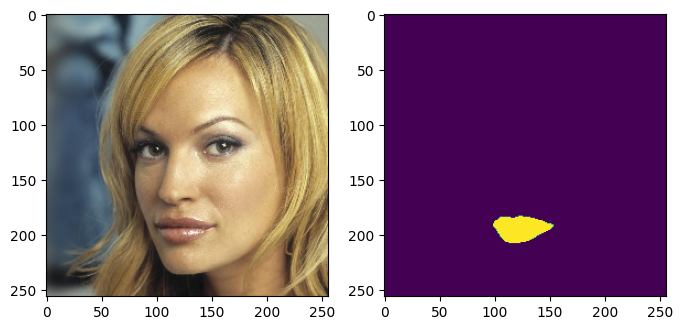

In [3]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

In [4]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
num_epochs = 1

Validation loop: 100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


Epoch 1/1 - Train loss: 1.0625452052680473, Validation loss: 0.8083477897859698
Best model weights saved at epoch 1 with validation loss: 0.8083


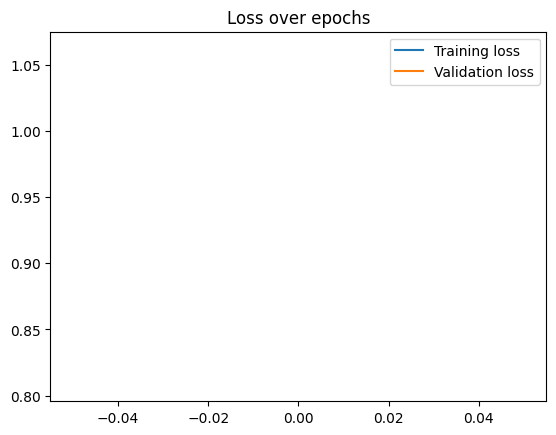

In [5]:
train_fn(train_loader, val_loader, model, optimizer, num_epochs, model_path='own_models/model_1_epoch.pth')

In [6]:
data_iter = iter(test_loader)

images, labels = next(data_iter)

images, labels = images.to(DEVICE), labels.to(DEVICE)

predictions = torch.sigmoid(model(images))


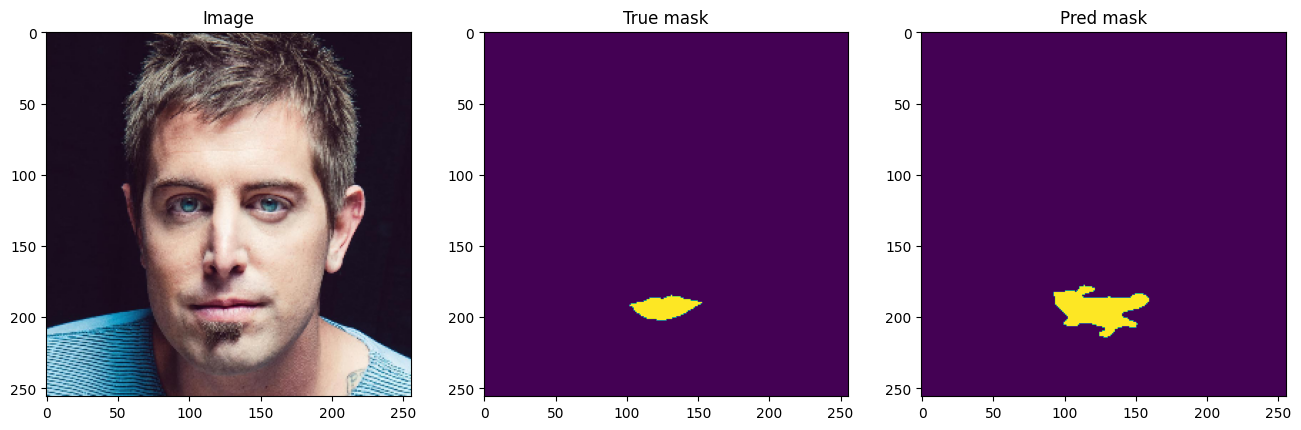

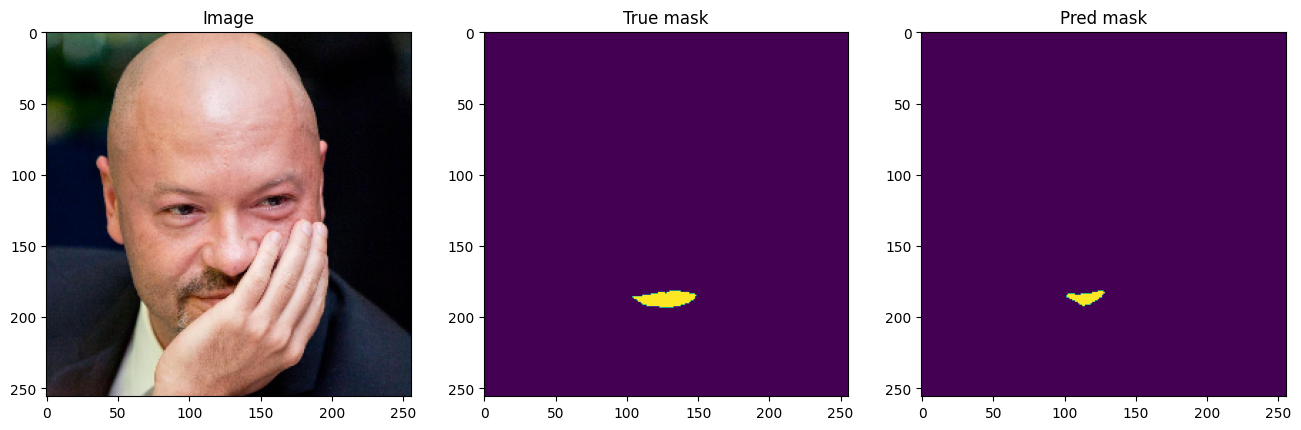

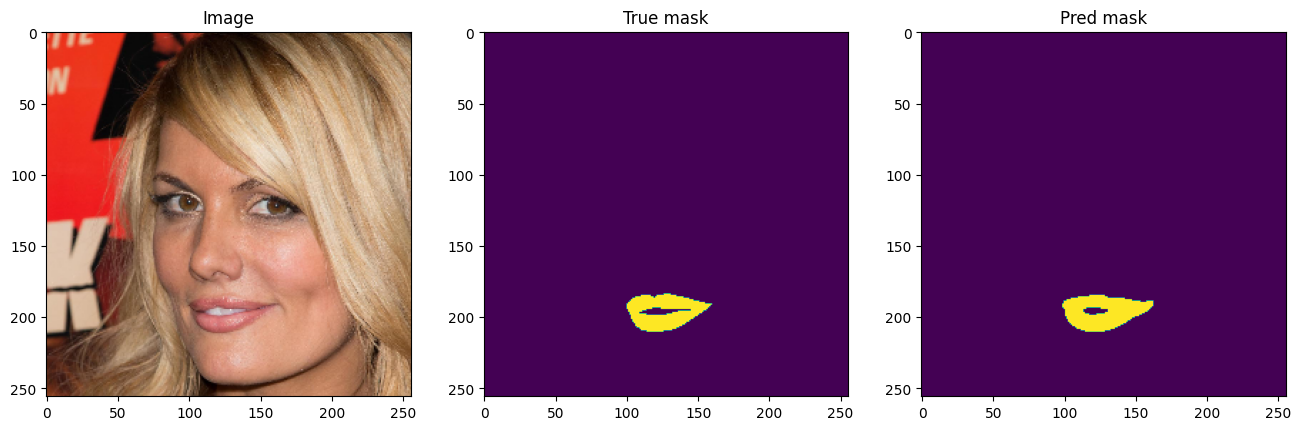

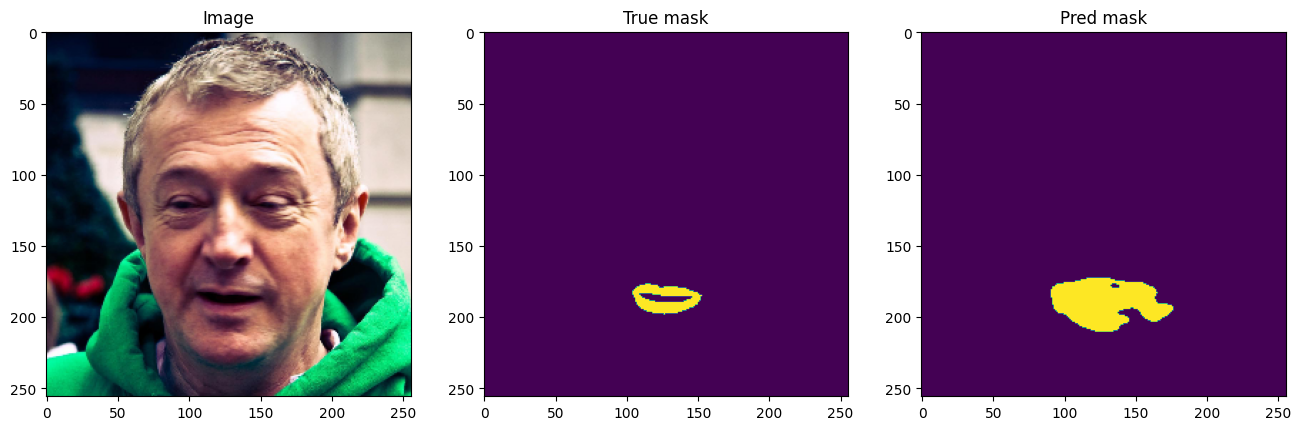

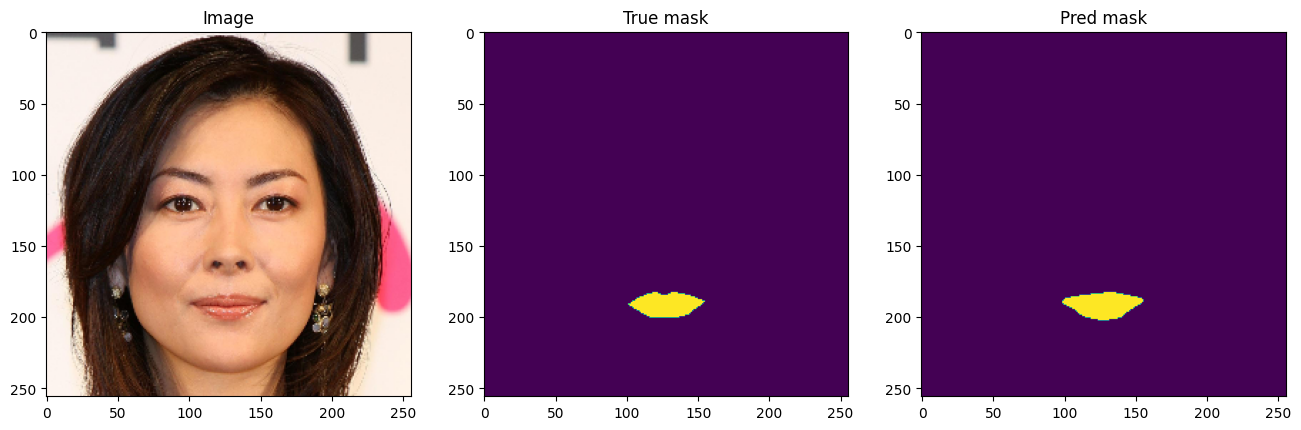

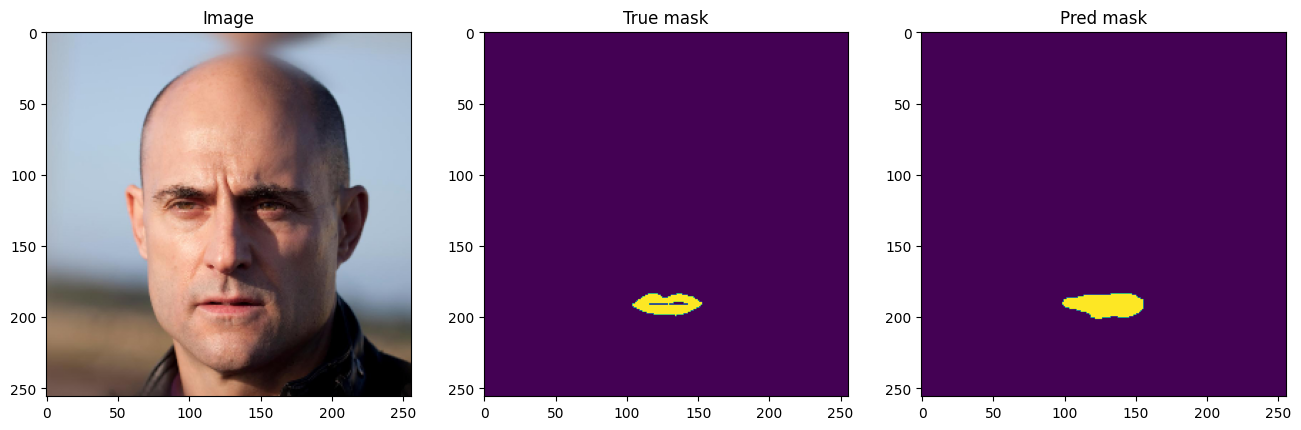

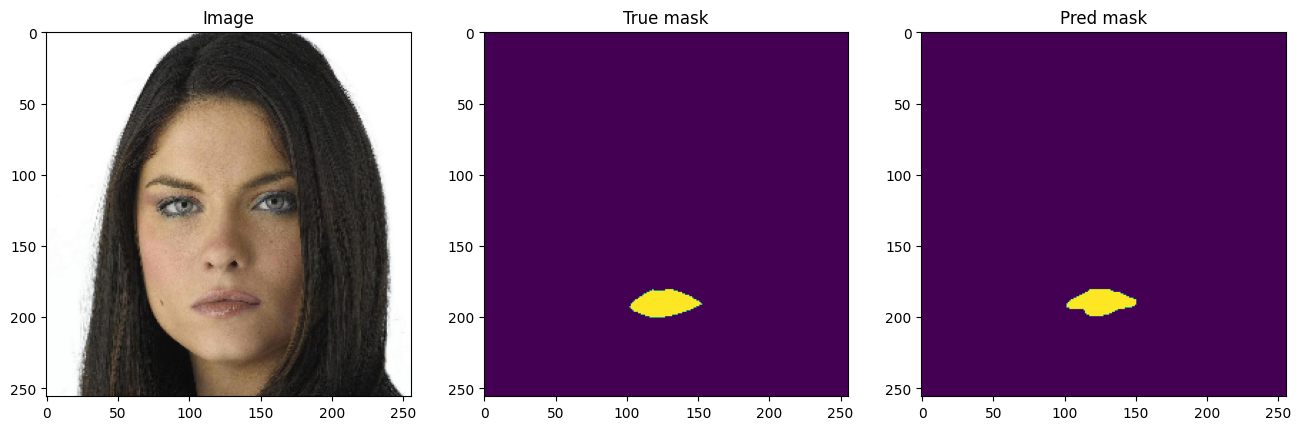

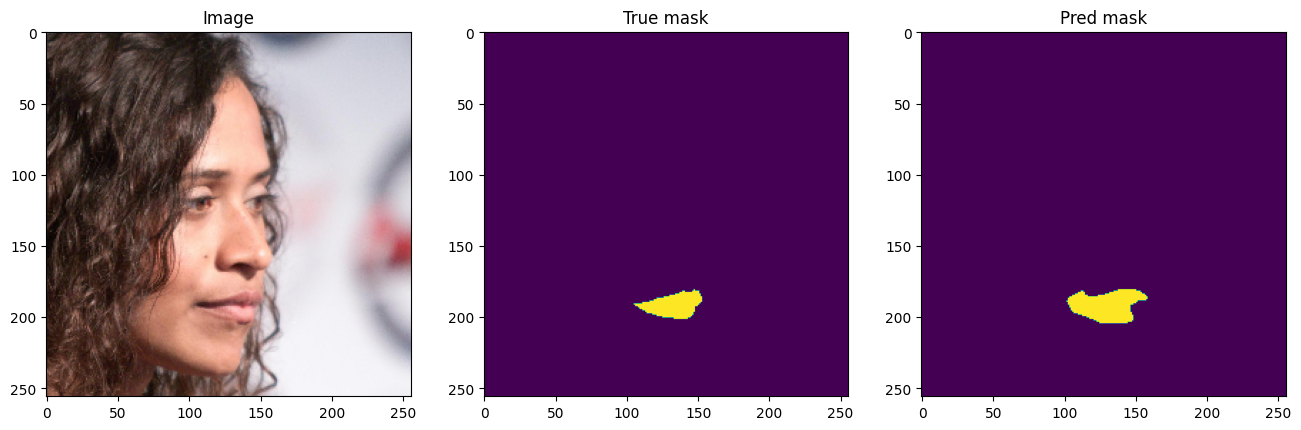

In [7]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True mask')

    pred = predictions.detach().cpu()[i, ].permute(1, 2, 0)
    pred_mask = (pred > 0.5).float()
    ax_3.imshow(pred_mask)
    ax_3.set_title('Pred mask')

In [8]:
def preprocess_img(image_path, new_size = (256,256)):
    image = cv2.imread(image_path)
    img = cv2.cvtColor(cv2.resize(image, new_size), cv2.COLOR_BGR2RGB)
        
    img = img.astype(float)
    img = torch.as_tensor(img, dtype=torch.float) / 255.0
    img = img.permute(2, 0, 1)  # Permutujemy do formatu (C, H, W)
    return img

In [13]:
def get_pred(img_path):
    image = preprocess_img(img_path)
    image = image.unsqueeze(0).float().to(DEVICE)
        

    model.eval()
    with torch.no_grad():  # Wyłączamy gradienty
        output = torch.sigmoid(model(image))

    output_image = output.squeeze(0).cpu().numpy()  # Usuń wymiar batcha i przenieś na CPU
    output_image = (output_image > 0.5).astype(np.uint8)  # Ustal próg dla maski
    output_image = np.transpose(output_image, (1, 2, 0))  # Zamień na szerokość, wysokość, kanały
    return output_image


In [9]:
def get_mask_on_photo(img, pred):
    mask = np.zeros_like(img)
    mask[:, :, 0] = pred[:, :, 0] * 255  # bierzemy czerwony jako usta
    alpha = 0.2
    masked_image = cv2.addWeighted(img, 1 - alpha, mask, alpha, 0)
    return masked_image

In [16]:
def print_prediction(path_img):
    img = cv2.imread(path_img)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = get_pred(path_img)
    masked_image = get_mask_on_photo(img, mask)

    fig = plt.figure(figsize = (16,5))
    a = fig.add_subplot(1, 3, 1)
    imgplot = plt.imshow(img)
    a.set_title('Input')
    a = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(mask)
    a.set_title('Output')
    a = fig.add_subplot(1, 3, 3)
    imgplot = plt.imshow(masked_image)


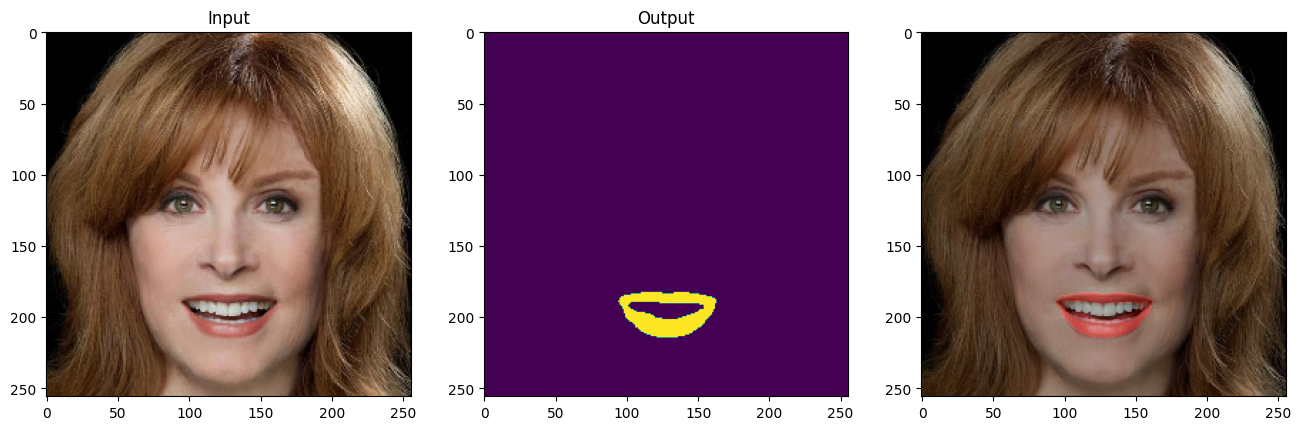

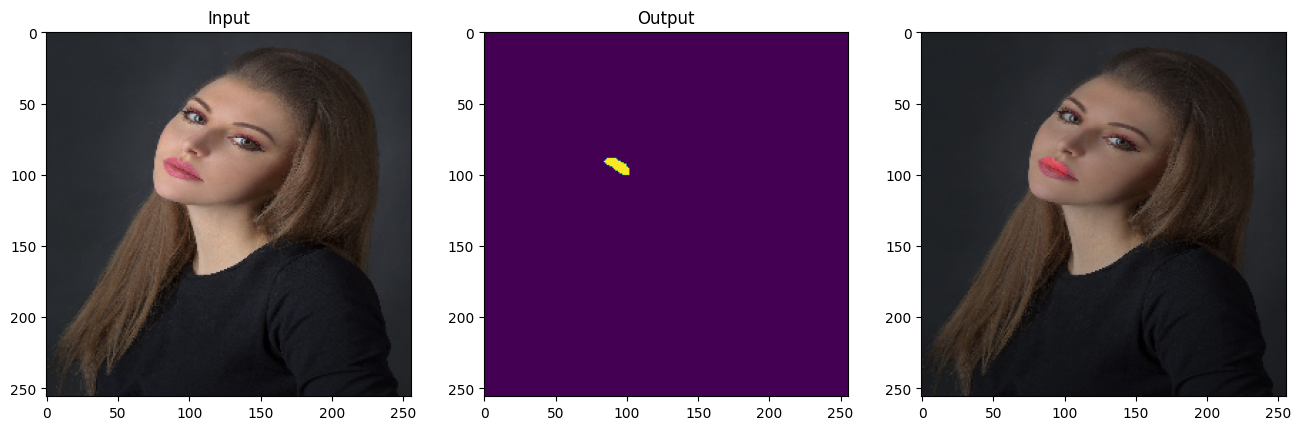

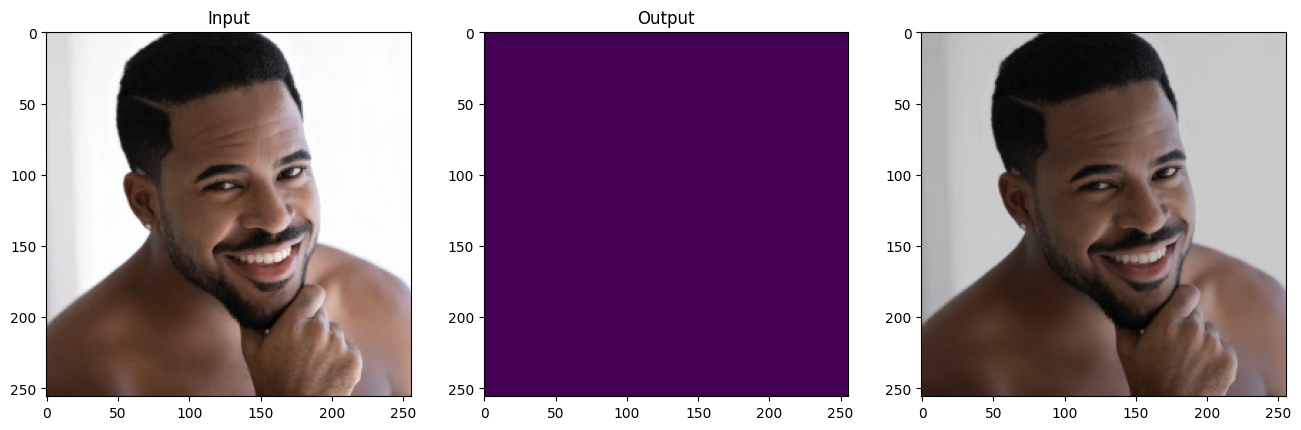

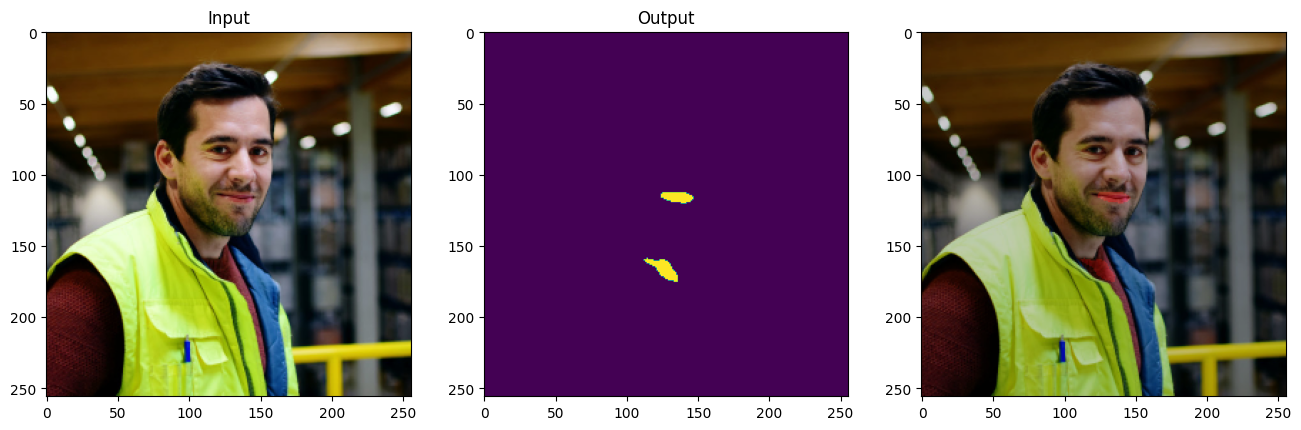

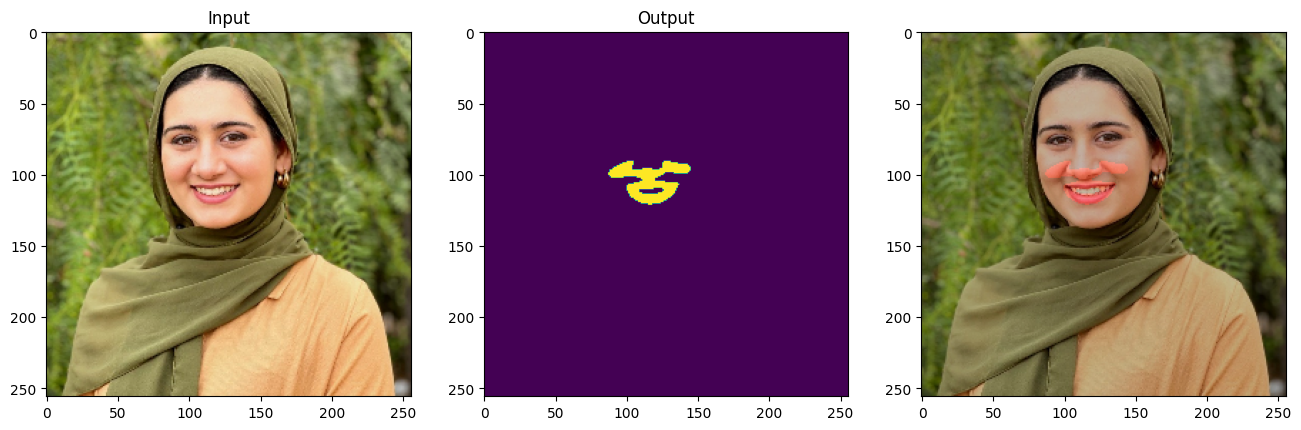

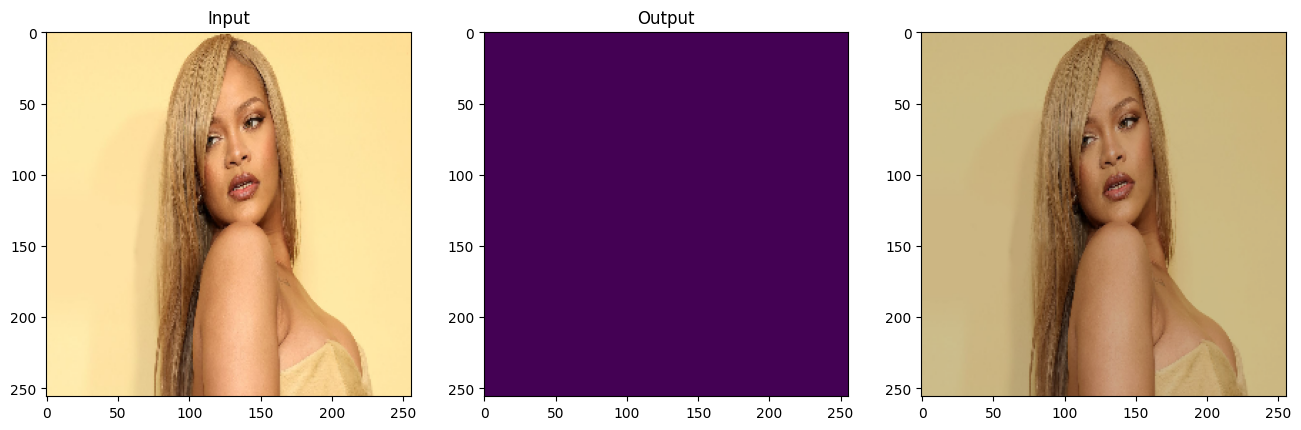

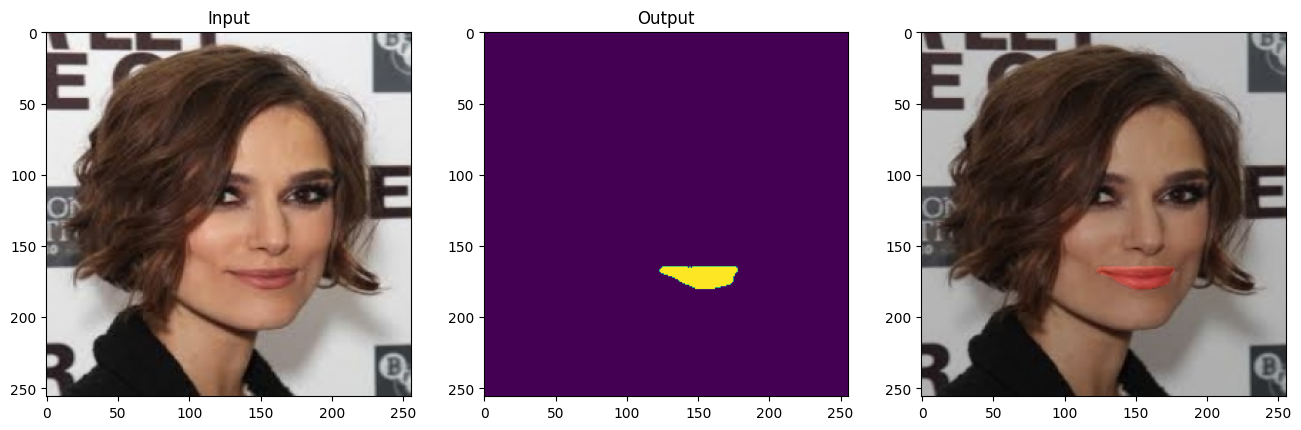

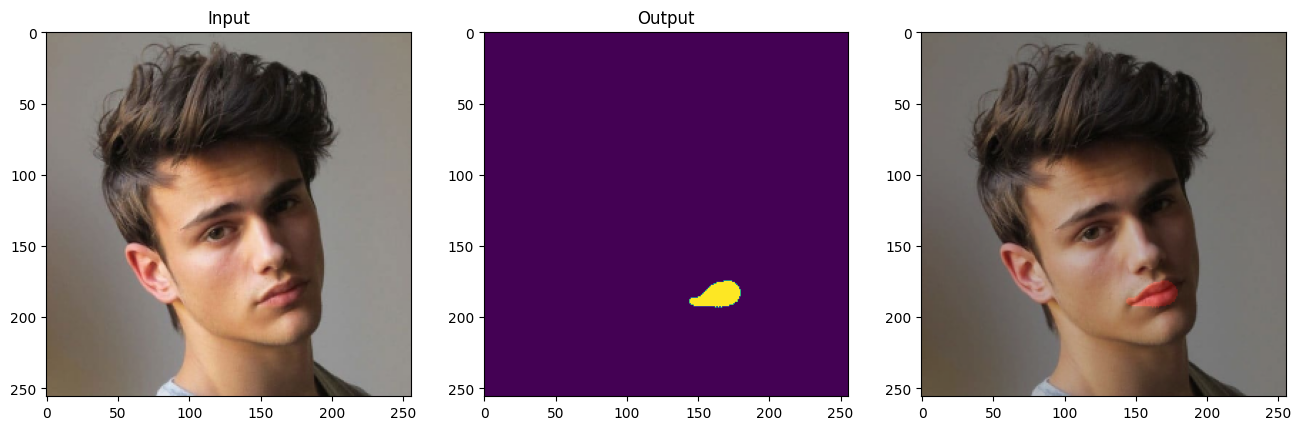

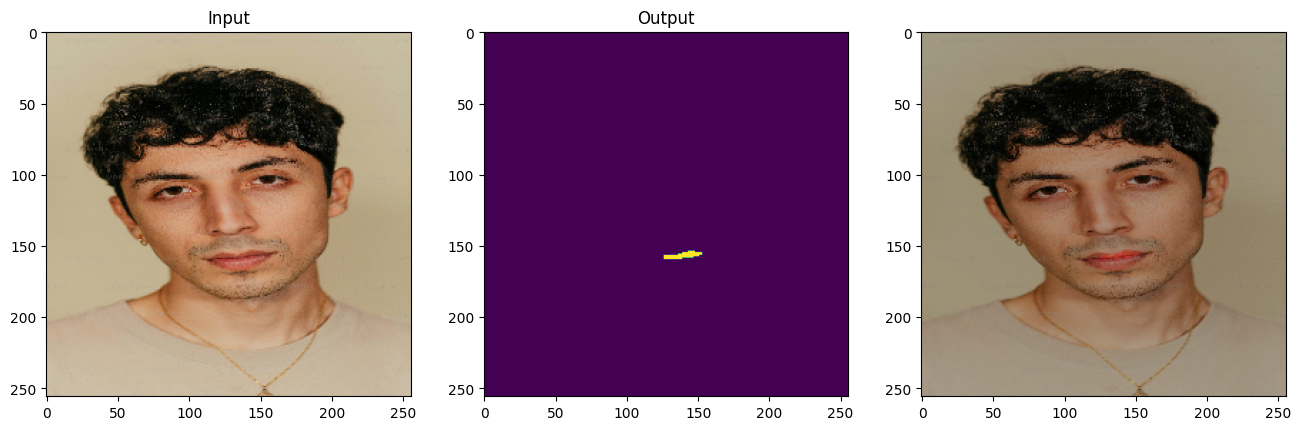

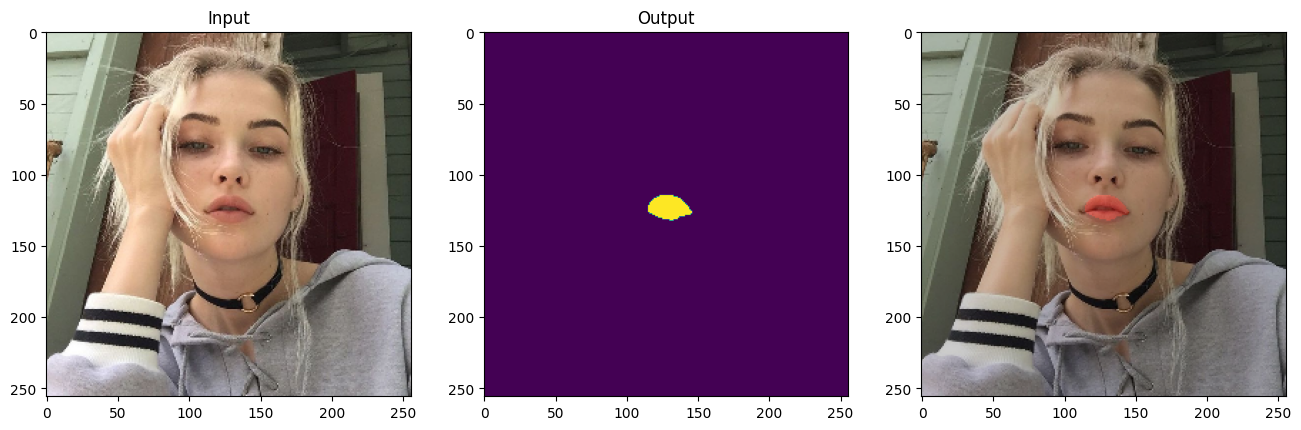

In [17]:
for i in range(10):
    print_prediction(f'C:\\Users\\aleks\\OneDrive\\Documents\\LIPS SEGMENTATION\\test_img\\test{i}.jpg')

In [19]:
PATH = "own_models/swoj_unet.pth"
torch.save(model.state_dict(), PATH)